# Testing bias metrics and mitigation algorithms on the Bank dataset

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OrdinalEncoder
from aif360.algorithms.preprocessing import Reweighing, DisparateImpactRemover
from matplotlib.gridspec import GridSpec
from Sampler import Sampler
from utility import *

## Dataset description

The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit (variable y). This dataset have been proven to be bias w.r.t. the `age` variable with a value >= 25.

## Dataset fairness metrics definition

The group fairness metrics related to the dataset are defined as follows:

- **Disparate impact**

$$
\frac{Pr(Y=1|S=unprivileged)}{Pr(Y=1|S=privileged)}
$$

> If the value is less than 0.8 or more than 1.2 we say that there is a _disparate impact_ on data

- **Statistical parity**

$$
Pr(Y=1|S=unprivileged)-Pr(Y=1|S=privileged)
$$

## Classifier fairness metrics definition

The group fairness metrics related to the classifier are defined below:

- **Balanced Accuracy**

$$
\frac{TP + TN}{2}
$$

- **Statistical parity**

$$
Pr(\hat{Y}=1|S=unprivileged)-Pr(\hat{Y}=1|S=privileged)
$$

- **Disparate Impact**

$$
\frac{Pr(\hat{Y}=1|S=unprivileged)}{Pr(\hat{Y}=1|S=privileged)}
$$

>If the value is less than 0.8 or more than 1.2 we say that there is a _disparate impact_ on data
- **Average odds difference**

$$
\frac{[(FPR_{S=unpriv} - FPR_{S=priv})+(TPR_{S=unpriv} - TPR_{S=priv})]}{2}
$$
>A value of 0 means _equality of odds_

- **Equal opportunity difference**

$$
TPR_{S=unpriv} - TPR_{S=priv}
$$

- **Theil Index**

$$
\frac{1}{n}\sum_{i=1}^n\frac{b_{i}}{\mu}\ln(\frac{b_{i}}{\mu}) \\
\text{with: } b_i=\hat{y_i}-y_i+1 \text{ and $\mu$ is the mean of $b_i$ }
$$
>Individual index measuring the distance of each individual predicted y from his real value. A value of 0 means equality. 

## Bias mitigation algorithms

In the following we will test two preprocessing bias mitigation algorithms and we will compare the impact they have on the model accuracy. The algorithms that we will test are the following:

1. **Reweighing**
    
> Reweighing is a preprocessing technique that Weights the examples in each (group, label) combination differently to ensure fairness before classification

2. **Disparate Impact Remover**

> This algorithm changes the values of the unsensitive variables at different levels of repair. An higher level of repair removes the disparate impact but loweres the accuracy, while a low level of repair does not change the data. The values of the unsensitive attributes are changed s.t. the correlation between the variables and the sensitive attribute _S_ is removed while keeping the ranking of the items for the classifier. In this way it is no more possible to predict the sensitive variable _S_ from the unsensitive attributes.
>
> Following the pre processing procedure suggested by M. Feldman et al. in _"Certifying and removing disparate impact." ACM SIGKDD International Conference on Knowledge Discovery and Data Mining, 2015_, we first scale the values s.t. the minimum is 0 and the maximum is 1 and then remove the sensitive variable from the dataset before training the classifier.
>
>**NB:** Categorical data must be transformed in ordered values

3. **Sampling**

> Sampling is a modified version of the Reweighing algorithm. First of all, it considered the groups made by each combinantion of the values of sensitive variables and labels. Then, for each group it computes his disparity ($\frac{size\_exp}{size\_obs}$) and samples each group untill this value becomes 1. The final dataset will be a dataset in which each group is balanced.

# Importing and exploring the dataset

In [2]:
df = pd.read_csv('bank/bank-additional-full.csv', sep=';')
for col in df.columns:
    df.drop(df[df[col] == 'unknown'].index, inplace=True)
df.loc[df['age']<25, 'age'] = 1
df.loc[df['age']!=1, 'age'] = 0

In [3]:
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,0,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,0,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,0,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,0,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
6,0,admin.,married,professional.course,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,0,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,0,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,0,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,0,technician,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


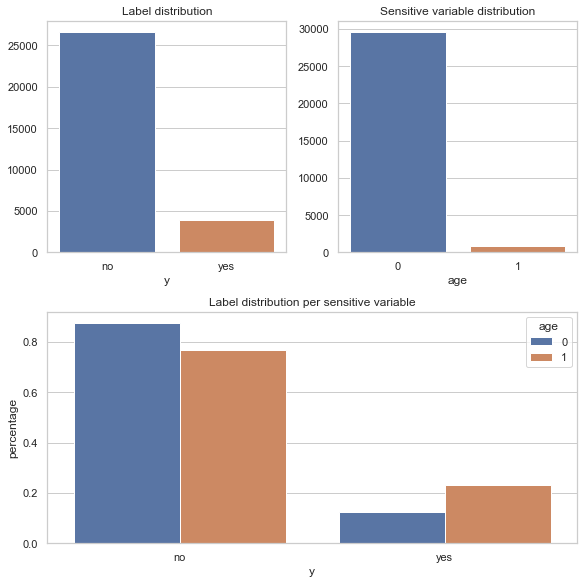

In [4]:
fig = plt.figure(constrained_layout=True, figsize=(8,8))
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[1,:])
sns.countplot(x='y', data=df, ax=ax1)
sns.countplot(x='age', data=df, ax=ax2)
sns.barplot(x='y',y='percentage',
            data=(df[['age','y']]
                 .groupby('age')['y']
                 .value_counts(normalize=True)
                 .rename('percentage')
                 .reset_index()),
            hue='age', ax=ax3
           )
ax1.set_title('Label distribution')
ax1.set_ylabel('')
ax2.set_ylabel('')
ax2.set_title('Sensitive variable distribution')
ax3.set_title('Label distribution per sensitive variable')
plt.show()

We are in an **unbalanced bias** case.

In [5]:
le = LabelEncoder()
dummy_cols = ['default', 'housing', 'loan', 'y']
for col in dummy_cols:
    df[col] = le.fit_transform(df[col])

In [6]:
cat_cols = ['job', 'marital', 'education', 'contact', 'month', 'day_of_week', 'poutcome']

In [7]:
for col in cat_cols:
    df = df.join(pd.get_dummies(df[col], prefix=col)).drop(col, axis=1)

In [8]:
priv_group=[{'age':1}]
unpriv_group=[{'age':0}]

In [9]:
bank = BinaryLabelDataset(df=df, label_names=['y'], protected_attribute_names=['age'])

# Bias dataset case

### Dataset Metrics:

Disparate Impact: 0.5367
Statistical Parity: -0.1068




### Classification Metrics:

Balanced accuracy: 0.8636
Statistical parity: -0.2170
Disparate impact: 0.5280
Average odds: -0.1085
Equal opportunity: -0.0530
Theil index: 0.0536


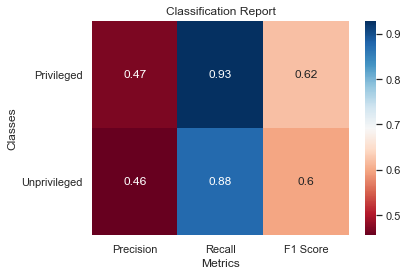

In [10]:
bias_class = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')), 
    bank, priv_group, unpriv_group)

# Reweighing

In [11]:
rw = Reweighing(unpriv_group, priv_group)
rw_data = bank.copy()

### Dataset Metrics:

Disparate Impact: 1.0000
Statistical Parity: -0.0000




### Classification Metrics:

Balanced accuracy: 0.8620
Statistical parity: -0.1057
Disparate impact: 0.7060
Average odds: -0.0065
Equal opportunity: 0.0354
Theil index: 0.0540


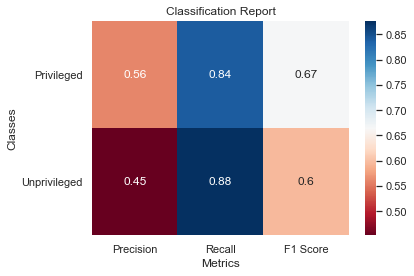

In [12]:
rw_class = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')), 
    rw_data, priv_group, unpriv_group, debiaser=rw)

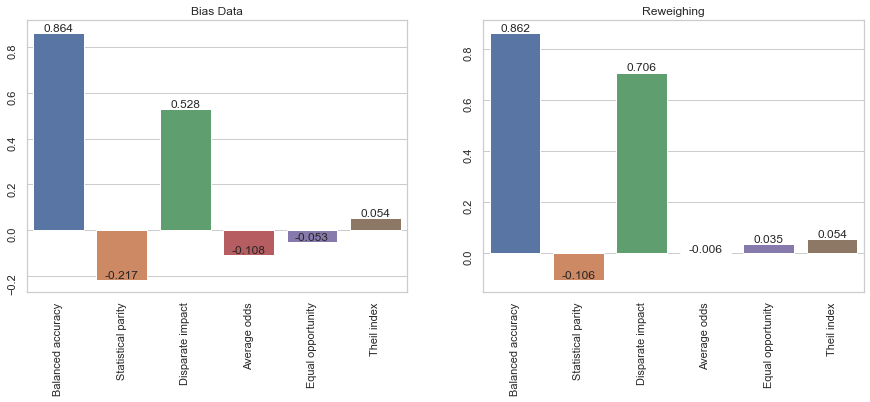

In [13]:
plot_metrics_comparison(bias_class, rw_class, 'Bias Data', 'Reweighing')
plt.show()

# Modified Reweighing (Sampling)

In [14]:
sampled_data = bank.copy()
sampler = Sampler(round_level=2)

### Dataset Metrics:

Disparate Impact: 0.9901
Statistical Parity: -0.0013




### Classification Metrics:

Balanced accuracy: 0.8624
Statistical parity: -0.1106
Disparate impact: 0.6852
Average odds: -0.0085
Equal opportunity: 0.0372
Theil index: 0.0539


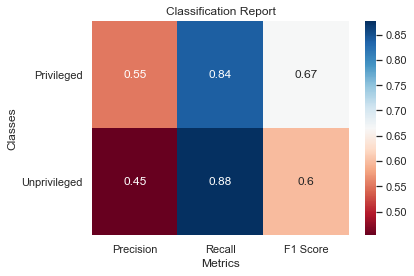

In [15]:
sampled_class = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')), 
    sampled_data, priv_group, unpriv_group, debiaser=sampler, n_splits=5)

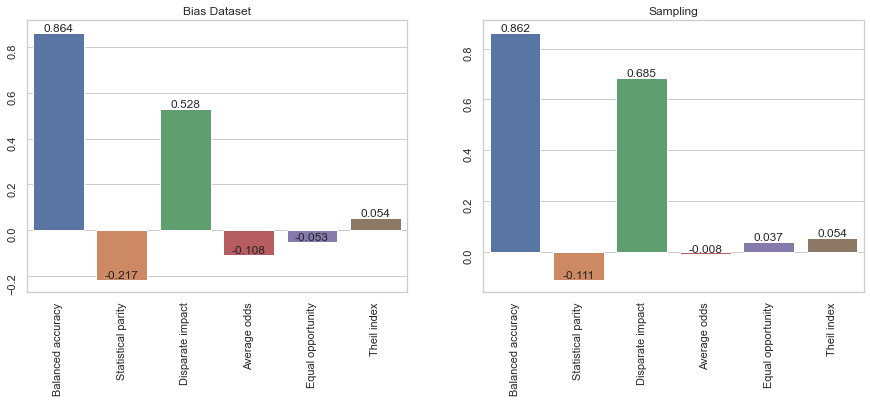

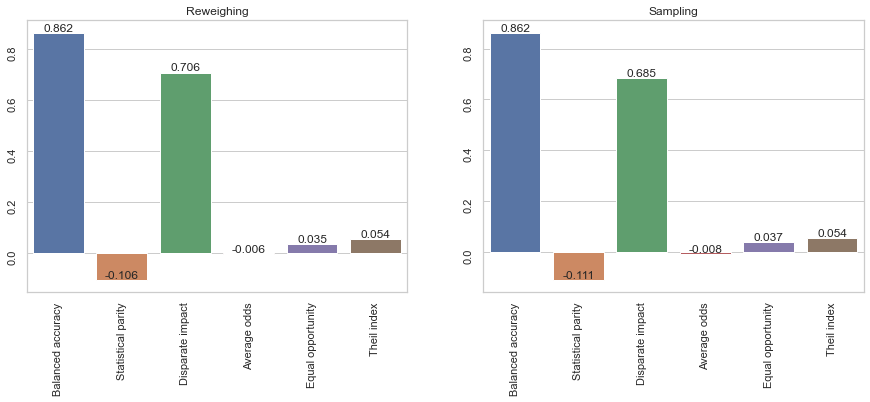

In [16]:
plot_metrics_comparison(bias_class, sampled_class, 'Bias Dataset', 'Sampling')
plot_metrics_comparison(rw_class, sampled_class, 'Reweighing', 'Sampling')
plt.show()

# Disparate Impact Remover

In [17]:
dir_data = bank.copy()
scaler = MinMaxScaler(copy=False)
dir_data.features = scaler.fit_transform(dir_data.features)
di = DisparateImpactRemover(sensitive_attribute='age')
dir_data = di.fit_transform(dir_data)

### Dataset Metrics:

Disparate Impact: 0.5367
Statistical Parity: -0.1068




### Classification Metrics:

Balanced accuracy: 0.8543
Statistical parity: -0.3758
Disparate impact: 0.3818
Average odds: -0.2445
Equal opportunity: -0.1420
Theil index: 0.0560


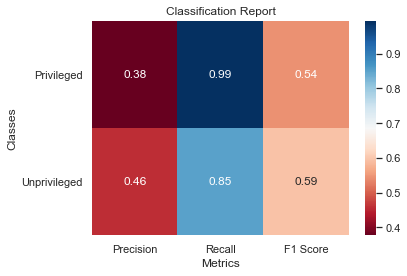

In [18]:
dir_class = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')), 
    dir_data, priv_group, unpriv_group, sensitive_attributes=['age'])

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


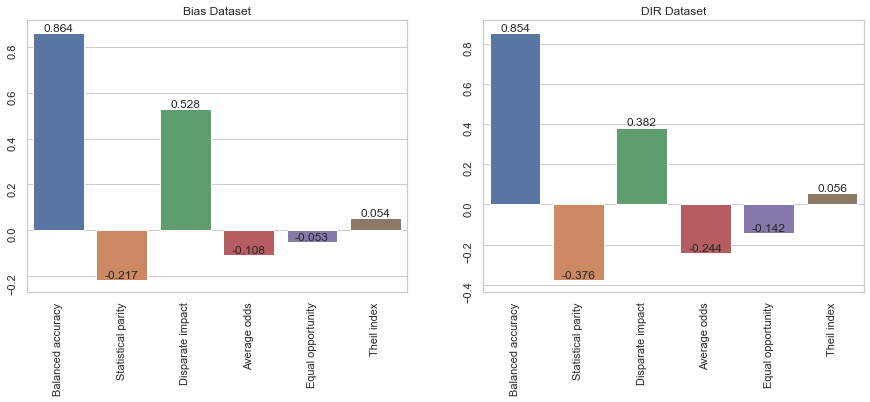

In [19]:
plot_metrics_comparison(bias_class, dir_class, 'Bias Dataset', 'DIR Dataset')
plt.show()

# Reweighing + DIR

### Dataset Metrics:

Disparate Impact: 1.0000
Statistical Parity: 0.0000




### Classification Metrics:

Balanced accuracy: 0.8538
Statistical parity: -0.3616
Disparate impact: 0.3938
Average odds: -0.2359
Equal opportunity: -0.1436
Theil index: 0.0562


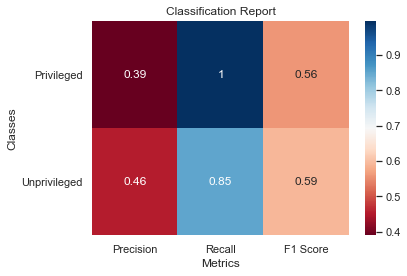

In [20]:
rw = Reweighing(unpriv_group, priv_group)
rw_dir_data = dir_data.copy()
rw_dir_class = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')), 
    rw_dir_data, priv_group, unpriv_group, sensitive_attributes=['age'], debiaser=rw)

# Algorithms comparison

metrics,Average odds,Balanced accuracy,Disparate impact,Equal opportunity,Statistical parity,Theil index
Dataset,,,,,,
Bias,-0.1085,0.8636,0.5280,-0.0530,-0.2170,0.0536
DIR,-0.2445,0.8543,0.3818,-0.1420,-0.3758,0.0560
RW + DIR,-0.2359,0.8538,0.3938,-0.1436,-0.3616,0.0562
Reweighed,-0.0065,0.8620,0.7060,0.0354,-0.1057,0.0540
Sampled,-0.0085,0.8624,0.6852,0.0372,-0.1106,0.0539


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


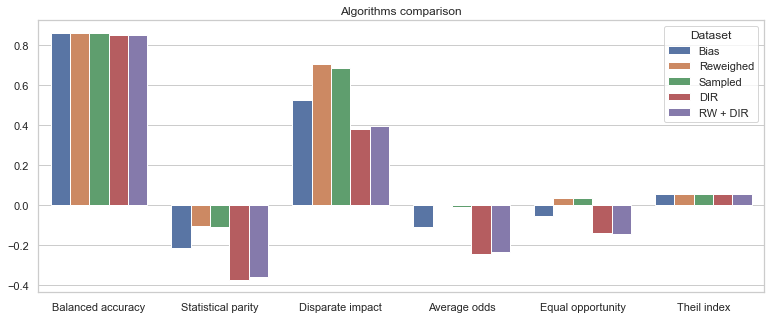

In [21]:
plot_syntesis(merge_datasets({
    'Bias': bias_class,
    'Reweighed': rw_class,
    'Sampled': sampled_class,
    'DIR': dir_class,
    'RW + DIR': rw_dir_class,
}), 'Algorithms comparison')
plt.show()